<a href="https://colab.research.google.com/github/Makena-WB/Book-Recommendation-Model/blob/main/RecModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357270 sha256=eec88aa1e5b66757f88a962a9ee7e99d5e96c316ed52186f2169f72c71818af0
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for content based filtering
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

#for collaborative filtering
import os
import math
import random

from surprise import accuracy, Reader, Dataset, dump
from surprise import NormalPredictor, KNNBasic, SVD, SVDpp
from surprise.model_selection import cross_validate, GridSearchCV

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

ratings = pd.read_csv('/content/drive/MyDrive/BookData/ratings.csv')
books = pd.read_csv('/content/drive/MyDrive/BookData/books_trimmed.csv')


Simple Recs

In [ ]:
def simple_recommender(Books, n=5):
    v = Books['ratings_count']
    m = Books['ratings_count'].quantile(0.95)
    R = Books['average_rating']
    C = Books['average_rating'].median()
    score = (v/(v+m) * R) + (m/(m+v) * C)
    Books['score'] = score

    qualified  = Books.sort_values('score', ascending=False)
    return qualified[['book_id', 'title', 'authors', 'average_rating', 'ratings_count','score']].head(n)

In [ ]:
simple_recommender(books)

,book_id,title,authors,average_rating,ratings_count,score
21,25,Harry Potter and the Deathly Hallows (Harry Po...,J.K. Rowling,4.61,1746574,4.56
23,27,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.54,1678823,4.49
15,18,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.53,1832823,4.49
20,24,Harry Potter and the Goblet of Fire (Harry Pot...,J.K. Rowling,4.53,1753043,4.48
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.44,4602479,4.43


Cosine Similarity

In [ ]:
def content(Books):
    Books['content'] = (pd.Series(Books[['authors', 'title', 'genres', 'description']]
                                  .fillna('')
                                  .values.tolist()
                                  ).str.join(' '))
    tf_content = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1, stop_words='english')
    tfidf_matrix = tf_content.fit_transform(Books['content'])
    cosine = linear_kernel(tfidf_matrix, tfidf_matrix)
    index = pd.Series(Books.index, index=Books['title'])
    return cosine, index

In [ ]:
def content_recommendation(Books, title, n=5):
    cosine_sim, indices = content(Books)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n + 1]
    book_indices = [i[0] for i in sim_scores]
    return Books[['book_id', 'title', 'authors', 'genres', 'description', 'average_rating', 'ratings_count']].iloc[book_indices]

In [ ]:
content_recommendation(books, '1984')

,book_id,title,authors,genres,description,average_rating,ratings_count
795,846,Animal Farm / 1984,George Orwell,"classics, fiction, sciencefiction, fantasy, ph...",this edition features george orwells best know...,4.26,116197
2048,2187,We,Yevgeny Zamyatin,"fiction, sciencefiction, classics",the exhilarating dystopian novel that inspired...,3.95,40020
3670,4004,Homage to Catalonia,George Orwell,"history, nonfiction, classics, memoir, biography",in 1936 george orwell travelled to spain to re...,4.14,22227
6857,8056,"1Q84 #1-2 (1Q84, #1-2)",Haruki Murakami,"fiction, fantasy, contemporary, sciencefiction",the year is 1984 and the city is tokyoa young ...,4.07,8342
4915,5510,The Far Side Gallery,Gary Larson,"comics, graphicnovels, fiction",1984 farworks inc all rights reserved the far ...,4.42,20022


Content + Popularity

In [ ]:
def improved_recommendation(Books, title, n=5):
    cosine_sim, indices = content(Books)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    books2 = Books.iloc[book_indices][['book_id', 'title', 'authors','genres', 'description', 'average_rating', 'ratings_count']]
    v = books2['ratings_count']
    m = books2['ratings_count'].quantile(0.75) #here the minimum rating is quantile 75
    R = books2['average_rating']
    C = books2['average_rating'].median()
    books2['new_score'] = (v/(v+m) * R) + (m/(m+v) * C)
    high_rating = books2[books2['ratings_count'] >= m]
    high_rating = high_rating.sort_values('new_score', ascending=False)
    return high_rating[['book_id', 'title', 'authors', 'genres', 'description', 'average_rating', 'ratings_count']].head(n)

In [ ]:
improved_recommendation(books, '1984')

,book_id,title,authors,genres,description,average_rating,ratings_count
795,846,Animal Farm / 1984,George Orwell,"classics, fiction, sciencefiction, fantasy, ph...",this edition features george orwells best know...,4.26,116197
759,809,Brave New World / Brave New World Revisited,Aldous Huxley,"classics, fiction, sciencefiction, fantasy, ph...",the astonishing novel brave new world original...,4.16,108124
604,649,1Q84,Haruki Murakami,"fiction, fantasy, sciencefiction, contemporary",the year is 1984 and the city is tokyoa young ...,3.89,125195
8168,14,Animal Farm,George Orwell,"classics, fiction, fantasy, sciencefiction, ph...",“all animals are equal but some animals are mo...,3.87,1881700
265,293,Treasure Island,Robert Louis Stevenson,"classics, fiction, youngadult, historicalficti...",for sheer storytelling delight and pure advent...,3.82,268012


collaborative

In [ ]:
# to have reproducible experiments
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# load the full dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings, reader)

# shuffle the ratings for unbiased result
all_ratings = data.raw_ratings
random.shuffle(all_ratings)

# split data into train and test data with the ratio 70:30
threshold = int(0.7 * len(all_ratings))
train_ratings = all_ratings[:threshold]
test_ratings = all_ratings[threshold:]

In [ ]:

def book_read(user_id):
    '''Take user_id and return list of book that user has read'''
    books_list = list(books['book_id'])
    book_read_list = list(ratings['book_id'][ratings['user_id'] == user_id])
    return books_list, book_read_list

In [ ]:
# prepare train data
data.raw_ratings = train_ratings

# select algorithm
npred = NormalPredictor()

In [ ]:
%%time
# cross validation for train data
np_result = cross_validate(npred, data, measures=['RMSE'], cv=5, verbose=True, n_jobs=2)

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3214  1.3230  1.3214  1.3229  1.3250  1.3227  0.0013  
Fit time          1.96    2.00    1.98    2.01    1.98    1.99    0.02    
Test time         4.58    4.76    5.16    4.74    4.56    4.76    0.22    
CPU times: user 1min 25s, sys: 4.66 s, total: 1min 30s
Wall time: 1min 34s


In [ ]:
%%time
#retrain whole train test
trainset = data.build_full_trainset()
npred.fit(trainset)

# Compute RMSE on trainset (without fold)
np_train_pred = npred.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(np_train_pred)

#compute RMSE on testset
testset = data.construct_testset(test_ratings)
np_test_pred = npred.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(np_test_pred)

Train RMSE:
RMSE: 1.3233
Test RMSE:
RMSE: 1.3236
CPU times: user 1min 16s, sys: 1.69 s, total: 1min 18s
Wall time: 1min 17s


In [ ]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_np', np_test_pred, npred)

In [ ]:
%%time

data.raw_ratings = all_ratings
npred.fit(data.build_full_trainset())

CPU times: user 18.7 s, sys: 488 ms, total: 19.2 s
Wall time: 19.1 s


In [ ]:
def get_recommendation_npred(user_id, n=5):
    '''Give n recommendation to user_id'''

    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]

    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = npred.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return books[books.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [ ]:
get_recommendation_npred(12874, 5)

,book_id,title,authors,average_rating,ratings_count
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,4780653
5,6,The Fault in Our Stars,John Green,4.26,2346404
24,28,Lord of the Flies,William Golding,3.64,1605019
39,45,Life of Pi,Yann Martel,3.88,1003228
40,46,Water for Elephants,Sara Gruen,4.07,1068146


SVD

In [ ]:
# change data to trainset
data.raw_ratings = train_ratings

# select algorithm
svd = SVD(random_state=0)

In [ ]:
%%time
# cross validation for train data
svd_result = cross_validate(svd, data, measures=["RMSE"], cv=5, verbose=True, n_jobs = 2)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8500  0.8492  0.8491  0.8500  0.8510  0.8499  0.0007  
Fit time          35.17   36.16   35.09   35.77   34.91   35.42   0.47    
Test time         7.01    7.75    6.62    6.66    6.54    6.92    0.45    
CPU times: user 1min 22s, sys: 4.04 s, total: 1min 26s
Wall time: 2min 37s


In [ ]:
%%time

# retrain whole train test
trainset = data.build_full_trainset()
svd.fit(trainset)

# compute RMSE on trainset (without fold)
svd_train_pred = svd.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svd_train_pred)

# compute RMSE on testset
testset = data.construct_testset(test_ratings)
svd_test_pred = svd.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svd_test_pred)

Train RMSE:
RMSE: 0.6441
Test RMSE:
RMSE: 0.8386
CPU times: user 2min 20s, sys: 1.84 s, total: 2min 22s
Wall time: 2min 21s


In [ ]:
# to dump the calculation result for future use
dump.dump('./dump_svd', svd_test_pred, svd)

In [ ]:
np_test_pred, npred = dump.load('./dump_np')
svd_test_pred, svd = dump.load('./dump_svd')

In [ ]:
# making the calculation result into dataframe
df_np = pd.DataFrame(np_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])

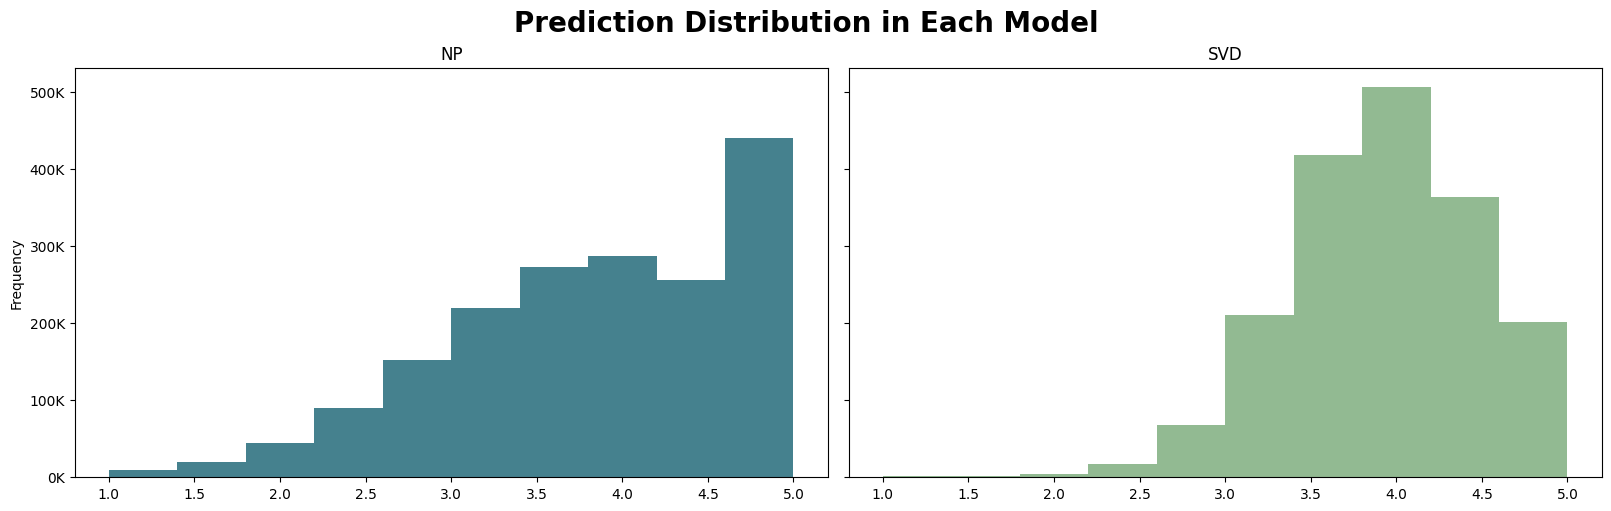

In [ ]:
# count the number of predictions for each rating value
figure, (ax1, ax2) = plt.subplots(1, 2,  figsize=(16, 5), sharey=True, constrained_layout=True)
df_np.est.plot(kind='hist', title='NP', ax=ax1, color='#45818E')
# Change ax3 to ax2 to use the second subplot you created
df_svd.est.plot(kind='hist', title='SVD', ax=ax2, color='#92BA92')
current_values = plt.gca().get_yticks() / 1000
plt.gca().set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in current_values])
plt.suptitle('Prediction Distribution in Each Model', weight='bold', fontsize=20)
plt.show()

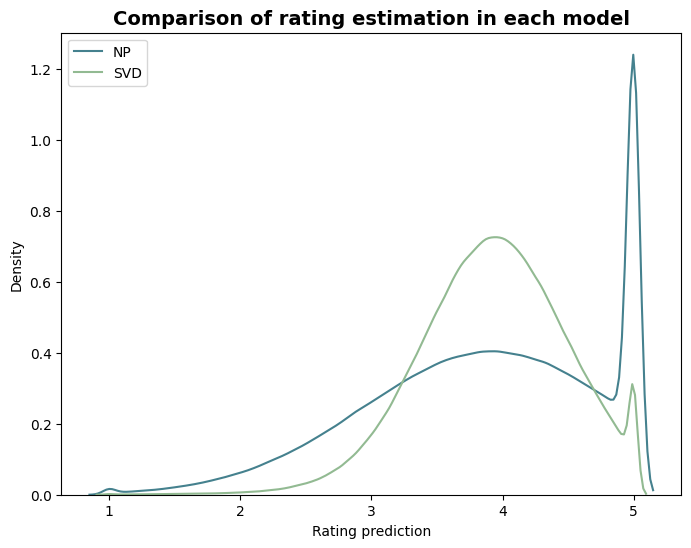

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_np['est'], shade=False, color='#45818E', label = 'NP', ax=ax)
sns.kdeplot(df_svd['est'], shade=False, color='#92BA92', label = 'SVD', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in each model', weight='bold', fontsize=14)
plt.show()

In [ ]:
def book_read(user_id):
    '''Take user_id and return list of book that user has read'''
    books_list = list(books['book_id'])
    book_read_list = list(ratings['book_id'][ratings['user_id'] == user_id])
    return books_list, book_read_list

In [ ]:
data.raw_ratings = all_ratings
npred.fit(data.build_full_trainset())

In [ ]:
def get_recommendation_npred(user_id, n=5):
    '''Give n recommendation to user_id'''

    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]

    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = npred.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return books[books.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [ ]:
get_recommendation_npred(12874, 5)

,book_id,title,authors,average_rating,ratings_count
14,17,"Catching Fire (The Hunger Games, #2)",Suzanne Collins,4.30,1831039
36,41,The Lightning Thief (Percy Jackson and the Oly...,Rick Riordan,4.23,1366265
40,46,Water for Elephants,Sara Gruen,4.07,1068146
53,60,The Curious Incident of the Dog in the Night-Time,Mark Haddon,3.85,867553
55,62,"The Golden Compass (His Dark Materials, #1)",Philip Pullman,3.94,953970


In [ ]:
%%time
# make recommendation on full dataset
data.raw_ratings = all_ratings
svd.fit(data.build_full_trainset())

CPU times: user 1min 51s, sys: 790 ms, total: 1min 52s
Wall time: 1min 51s


In [ ]:
def get_recommendation_svd(user_id, n=5):
    '''Give n recommendation to user_id'''

    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]

    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svd.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return books[books.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [ ]:
get_recommendation_svd(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
194,215,Ready Player One,Ernest Cline,4.31,349423
226,250,Wonder,R.J. Palacio,4.43,228538
390,425,Go Ask Alice,Beatrice Sparks,3.77,196677
1698,1808,"Morning Star (Red Rising, #3)",Pierce Brown,4.50,47736


Hyperparameter Tuning

In [ ]:
# prepare train data
data.raw_ratings = train_ratings

In [ ]:
%%time
grid = {'n_epochs': [20, 30],
        'lr_all': [.005, .001],
        'reg_all': [0.02, 0.04]}
gs = GridSearchCV(SVD, grid, measures=['RMSE'], cv=5, n_jobs=2)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8383609722127033
{'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.04}
CPU times: user 4min 15s, sys: 19.9 s, total: 4min 35s
Wall time: 18min 54s


In [ ]:
# select best algorithm
svdtuned = gs.best_estimator['rmse']

In [ ]:
%%time

#retrain whole train test (without fold)
trainset = data.build_full_trainset()
svdtuned.fit(trainset)

# compute RMSE on trainset (without fold)
svdtuned_train_pred = svdtuned.test(trainset.build_testset())
print('Train RMSE:')
train_rmse = accuracy.rmse(svdtuned_train_pred)

# compute RMSE on testset
testset = data.construct_testset(test_ratings)
svdtuned_test_pred = svdtuned.test(testset)
print('Test RMSE:')
test_rmse = accuracy.rmse(svdtuned_test_pred)

Train RMSE:
RMSE: 0.6575
Test RMSE:
RMSE: 0.8268
CPU times: user 2min 49s, sys: 2.79 s, total: 2min 52s
Wall time: 2min 51s


In [ ]:
%%time

data.raw_ratings = all_ratings
svdtuned.fit(data.build_full_trainset())

CPU times: user 2min 45s, sys: 817 ms, total: 2min 46s
Wall time: 2min 46s


In [ ]:
def get_recommendation(user_id, n=5):
    '''Give n recommendation to user_id'''

    all_books, user_books =  book_read(user_id)
    next_books = [book for book in all_books if book not in user_books]

    if n <= len(next_books):
        ratings = []
        for book in next_books:
            est = svdtuned.predict(user_id, book).est
            ratings.append((book, est))
        ratings = sorted(ratings, key=lambda x: x[1], reverse=True)
        book_ids = [id for id, rate in ratings[:n]]
        return books[books.book_id.isin(book_ids)][['book_id', 'title', 'authors', 'average_rating', 'ratings_count']]
    else:
        print('Please reduce your recommendation request')
        return

In [ ]:
get_recommendation(12874, 5)

,book_id,title,authors,average_rating,ratings_count
27,31,The Help,Kathryn Stockett,4.45,1531753
241,267,The Nightingale,Kristin Hannah,4.54,253606
810,862,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,4.77,73572
4383,4868,Jesus the Christ,James E. Talmage,4.63,17179
5822,6659,Hamilton: The Revolution,LinManuel Miranda,4.47,24800


In [ ]:
# uncomment this code to dump the calculation result for future use
dump.dump('./dump_tuning', svdtuned_test_pred, svdtuned)

In [ ]:
# uncomment this code to load the dump file
svd_test_pred, svd = dump.load('./dump_svd')
svdtuned_test_pred, svdtuned = dump.load('./dump_tuning')


In [ ]:
df_svd = pd.DataFrame(svd_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svdtuned = pd.DataFrame(svdtuned_test_pred, columns=['uid', 'iid', 'rui', 'est', 'details'])


NameError: name 'df_svdtuned' is not defined

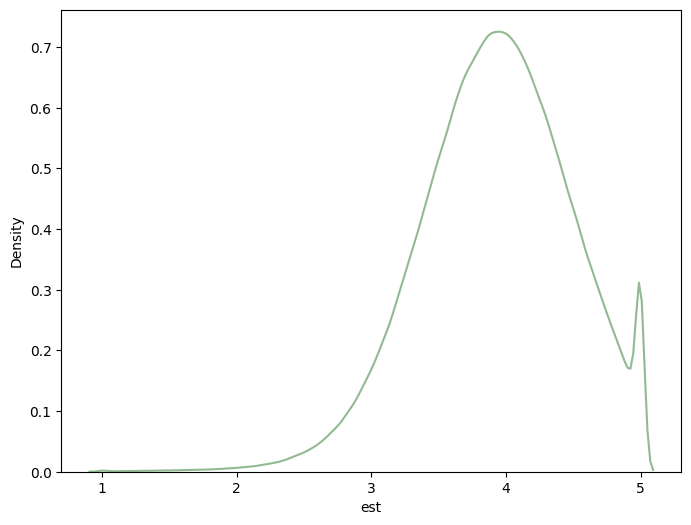

In [ ]:
# visualization
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(df_svd['est'], shade=False, color='#92BA92', label = 'SVD', ax=ax)
sns.kdeplot(df_svdtuned['est'], shade=False, color='#DEBA9D', label = 'Tuned SVD', ax=ax)
ax.legend()
plt.xlabel('Rating prediction')
plt.ylabel('Density')
plt.title('Comparison of rating estimation in SVD and Tuned SVD')
plt.show()